In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import os

from PIL import Image
import xml.etree.ElementTree as ET

from tensorflow.keras import *

import seaborn as sns

from sklearn.decomposition import PCA

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import svm

**<span style="font-size:1.7em;">Data Preprocessing:</span>**

In [2]:
# Takes as input the folder name containing image data
# Returns two lists: a list containing the images in a single folder, and a list of image file names in same folder
def load_images(folder_name):
    
    images = []
    file_names = []
    
    for fname in sorted(os.listdir(folder_name)):
        if '.JPG' in fname: 
            img = np.asarray(Image.open(folder_name+fname))
            if img is not None:
                images.append(img)
                file_names.append(fname[:-4])
            
    return file_names, images

In [3]:
# Takes as input file name of a single image, and the folder name containing that image
# Returns the label containing the annotations for each individual tree in a single image
def get_label(folder_name,file_name):
    
    # parse xml file
    tree = ET.parse(folder_name+file_name+'.xml')
    root = tree.getroot()
    
    # generate dictionary
    object_list = []
    for object_elem in root.findall('.//object'):
        object_dict = {}
        object_dict['id'] = object_elem.get('id')
        for child_elem in object_elem:
            object_dict[child_elem.tag] = child_elem.text
            for grandchild_elem in child_elem:
                object_dict[grandchild_elem.tag] = grandchild_elem.text
        object_list.append(object_dict)
    
    # dictionary to pd dataframe
    label = pd.DataFrame(object_list)
    
    return label

In [4]:
# Takes as input a single image, label containing annotations of that image, and desired size of
#    each individual tree image data
# Returns a list of cropped and resized trees from a single image according to the specified size
def process_image(image, label, img_size, interpolation, sharpen_image):
    
    trees = []
    
    for i in range(len(label)):

        # Crop individual tree
        processed_img = image[int(label.ymin[i]):int(label.ymax[i]), int(label.xmin[i]):int(label.xmax[i])]

        # Sharpen small images if specified
        processed_image_size = (int(label.ymax[i])-int(label.ymin[i]))*(int(label.xmax[i])-int(label.xmin[i]))
        if sharpen_image and processed_image_size < img_size[0]**2:
            # Filtering Kernel for sharpening
            kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
            processed_img=cv2.filter2D(processed_img,-1,kernel)

        # Resize individual tree
        processed_img = cv2.resize(processed_img, (img_size[0], img_size[1]), interpolation = interpolation)

        trees.append(processed_img)
    
    return trees

In [5]:
# Takes as input folder name contating image data, and desired size of each individual tree image data
# Returns labeled training image data, as well as labeled test data
def process_data(folder_name, 
                 subfolders, 
                 img_size = [100, 100], 
                 interpolation=cv2.INTER_CUBIC, 
                 omit_truncated=False, 
                 sharpen_image=False):
    
    x_data = []
    y_labels = []
        
    file_names, images = load_images(folder_name+subfolders[0])
    
    for file_name, image in zip(file_names, images):
        label = get_label(folder_name+subfolders[1], file_name)
        trees = process_image(image, label, img_size, interpolation, sharpen_image)
        
        tmp_label = np.zeros(2)
        for i, tree in enumerate(trees):
            if int(label.truncated[i])==0 or not omit_truncated:
                x_data.append(tree)
                y_labels.append({"tree": label.tree[i], "damage": label.damage[i]})
    
    return np.array(x_data), np.array(y_labels).reshape(-1,1)

In [6]:
# Returns processed and labeled data from directories
def get_labeled_data(data_path_list, subfolders_path_list, img_size, interpolation, omit_truncated, sharpen_image):
    
    # Data from Forest 1 directory
    x1_train, y1_train = process_data(data_path_list[0], subfolders_path_list[0], img_size, interpolation, omit_truncated, sharpen_image)
    x1_test, y1_test = process_data(data_path_list[0], subfolders_path_list[1], img_size, interpolation, omit_truncated, sharpen_image=False)

    # Data from Forest 2 directory
    x2_train, y2_train = process_data(data_path_list[1], subfolders_path_list[0], img_size, interpolation, omit_truncated, sharpen_image)
    x2_test, y2_test = process_data(data_path_list[1], subfolders_path_list[1], img_size, interpolation, omit_truncated, sharpen_image=False)
        
    return np.vstack((x1_train, x2_train)), np.vstack((x1_test, x2_test)), np.vstack((y1_train, y2_train)), np.vstack((y1_test, y2_test))

In [7]:
# tree contains labels: larch (1 0), other (0 1)
# damage contains labels: HD: high damage (1 0 0 0),LD: low damage (0 1 0 0), H: healthy (0 0 1 0), other (0 0 0 1)

# transform labels to One-Hot Encoding format for training
def to_one_hot_encoding(y_labels):
    
    y_tree_ohe = []
    y_damage_ohe = []
    
    for y_label in y_labels:
        if y_label[0]['tree']=='Larch':
            y_tree_ohe.append(0)
        elif y_label[0]['tree']=='Other':
            y_tree_ohe.append(1)
            
        if y_label[0]['damage']=='HD':
            y_damage_ohe.append(0)
        elif y_label[0]['damage']=='LD':
            y_damage_ohe.append(1)
        elif y_label[0]['damage']=='H':
            y_damage_ohe.append(2)
        elif y_label[0]['damage']=='other':
            y_damage_ohe.append(3)
        
    return np.eye(2)[y_tree_ohe], np.eye(4)[y_damage_ohe]

In [8]:
# Convert RGB image to greyscale
def rgb_to_greyscale(x_data):

    x_data_greyscale = []

    for x in x_data:
        x = Image.fromarray(x).convert('L')
        x_data_greyscale.append(np.asarray(x))

    return np.array(x_data_greyscale)

**Main method to run for getting all the training and testing data:**

In [9]:
# Specify image size for resizing
img_size = [100,100]
# Choose interpolation type: cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA
interpolation = cv2.INTER_CUBIC
# Specify wether to omit truncated images or not
omit_truncated = False
# Choose wether to sharpen small sized images or not
sharpen_image = False

data_path_list = ['./data/Forest1/', './data/Forest2/']

subfolders_path_list = [['train_images/', 'train_annotations/'],
                        ['test_images/'  , 'test_annotations/']]

# Get all data
x_train, x_test, y_train, y_test = get_labeled_data(data_path_list, 
                                                    subfolders_path_list, 
                                                    img_size, 
                                                    interpolation, 
                                                    omit_truncated, 
                                                    sharpen_image)

# transform x_data to greyscale for nearest neighbor and SVM classification
x_train_greyscale = rgb_to_greyscale(x_train)
x_test_greyscale = rgb_to_greyscale(x_test)

# Transform labels which are stored in dictionaries to one hot encoding format
y_train_tree_ohe, y_train_damage_ohe = to_one_hot_encoding(y_train)
y_test_tree_ohe, y_test_damage_ohe = to_one_hot_encoding(y_test)

print(y_train)
print(y_train_damage_ohe)

[[{'tree': 'Larch', 'damage': 'HD'}]
 [{'tree': 'Larch', 'damage': 'HD'}]
 [{'tree': 'Larch', 'damage': 'HD'}]
 ...
 [{'tree': 'Other', 'damage': 'other'}]
 [{'tree': 'Other', 'damage': 'other'}]
 [{'tree': 'Larch', 'damage': 'HD'}]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [10]:
# Investigate shapes of training and test data vectors:
print('x_train.shape: ', x_train.shape, ',y_train_tree_ohe.shape: ', y_train_tree_ohe.shape, ',y_train_damage_ohe.shape: ', y_train_damage_ohe.shape)
print('x_test.shape: ', x_test.shape, ',y_test_tree_ohe.shape: ', y_test_tree_ohe.shape, ',y_test_damage_ohe.shape: ', y_test_damage_ohe.shape)
print('x_train_greyscale.shape: ', x_train_greyscale.shape)
print('x_test_greyscale.shape: ', x_test_greyscale.shape)

x_train.shape:  (20522, 100, 100, 3) ,y_train_tree_ohe.shape:  (20522, 2) ,y_train_damage_ohe.shape:  (20522, 4)
x_test.shape:  (1029, 100, 100, 3) ,y_test_tree_ohe.shape:  (1029, 2) ,y_test_damage_ohe.shape:  (1029, 4)
x_train_greyscale.shape:  (20522, 100, 100)
x_test_greyscale.shape:  (1029, 100, 100)


In [11]:
# Visualization of image data and labels, only 36 pairs are shown
def show_images(train_images, train_labels, nb_row = 6):
    
    plt.figure(figsize=(11, 11))
    for i in range(nb_row**2):
        plt.subplot(nb_row, nb_row, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(train_images[i])
        plt.xlabel(train_labels[i][0]['tree']+', '+train_labels[i][0]['damage'])
    plt.show()

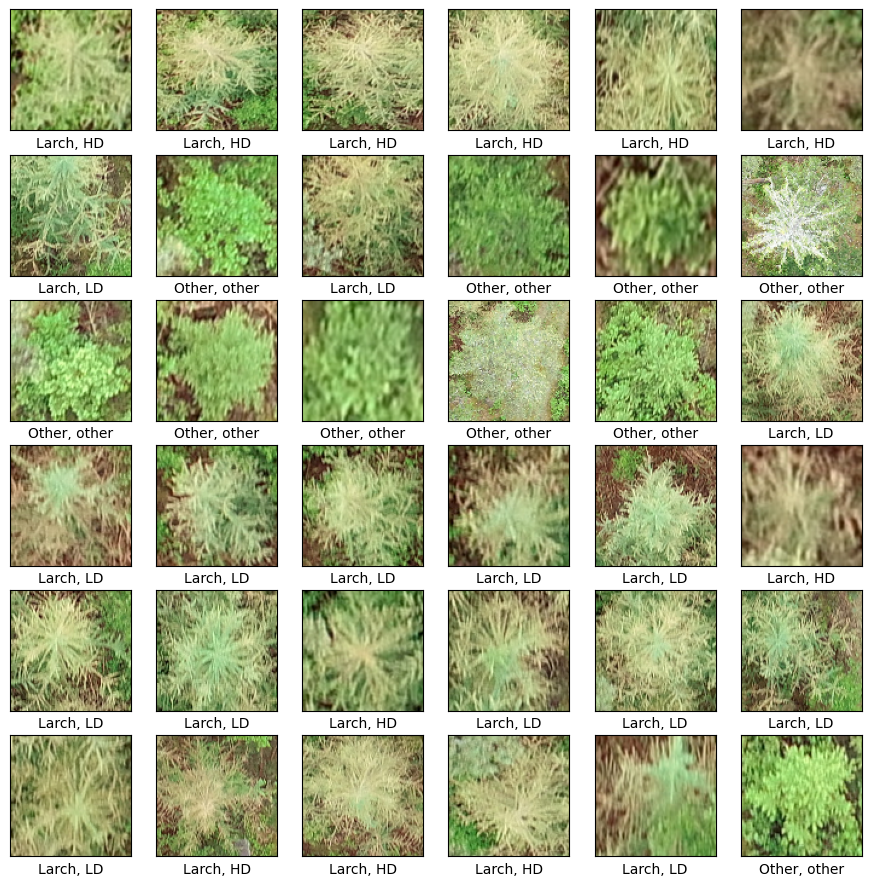

In [12]:
show_images(x_train, y_train)

**<span style="font-size:1.6em;">Data Augmentation:</span>**

In [13]:
# Investigate the training data

count_HD = 0
count_LD = 0
count_H = 0
count_other = 0

for y in y_train:
    if y[0]["damage"] == 'HD': count_HD += 1
    if y[0]["damage"] == 'LD': count_LD += 1
    if y[0]["damage"] == 'H': count_H += 1
    if y[0]["damage"] == 'other': count_other += 1

print('count_HD: ', count_HD, '\ncount_LD: ', count_LD, '\ncount_H: ', count_H, '\ncount_other: ', count_other)

# Clearly the data is not balanced between different classes ==> Data Augmentation

count_HD:  3215 
count_LD:  12707 
count_H:  1659 
count_other:  2941


In [14]:
# Data Augmentation to balance the data - not for LD images since they are already a lot

# Split the training data according to classes
x_train_HD = []
x_train_LD = []
x_train_H = []
x_train_other = []

for x, y in zip(x_train, y_train):
    if y[0]["damage"] == 'HD':      x_train_HD.append(x)
    elif y[0]["damage"] == 'LD':    x_train_LD.append(x)
    elif y[0]["damage"] == 'H':     x_train_H.append(x)
    elif y[0]["damage"] == 'other': x_train_other.append(x)

x_train_HD = np.array(x_train_HD)
x_train_LD = np.array(x_train_LD)
x_train_H = np.array(x_train_H)
x_train_other = np.array(x_train_other)

# Create an ImageDataGenerator object with augmentation parameters
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define the number of augmented images you want to generate for each class
num_augmented_HD = count_LD - count_HD 
num_augmented_H = count_LD - count_H
num_augmented_other = count_LD - count_other

# Create an empty array to store the augmented images
x_train_HD_augmented = np.zeros((num_augmented_HD, 100, 100, 3), dtype=np.uint8)
x_train_H_augmented = np.zeros((num_augmented_H, 100, 100, 3), dtype=np.uint8)
x_train_other_augmented = np.zeros((num_augmented_other, 100, 100, 3), dtype=np.uint8)

# Use the flow method to generate augmented images
augmented_images_HD = datagen.flow(x_train_HD, batch_size=1)
augmented_images_H = datagen.flow(x_train_H, batch_size=1)
augmented_images_other = datagen.flow(x_train_other, batch_size=1)

# Generate and store augmented images
for i in range(num_augmented_HD):
    augmented_image = next(augmented_images_HD)[0]
    x_train_HD_augmented[i] = augmented_image

for i in range(num_augmented_H):
    augmented_image = next(augmented_images_H)[0]
    x_train_H_augmented[i] = augmented_image

for i in range(num_augmented_other):
    augmented_image = next(augmented_images_other)[0]
    x_train_other_augmented[i] = augmented_image

# Now x_augmented contains the augmented images
print("Augmented HD images shape:", x_train_HD_augmented.shape)
print("Augmented H images shape:", x_train_H_augmented.shape)
print("Augmented other images shape:", x_train_other_augmented.shape)

Augmented HD images shape: (9492, 100, 100, 3)
Augmented H images shape: (11048, 100, 100, 3)
Augmented other images shape: (9766, 100, 100, 3)


In [15]:
# Stack all training images together with their corresponding labels

tmp_HD = [0]*num_augmented_HD
tmp_H = [2]*num_augmented_H
tmp_other = [3]*num_augmented_other

x_train_augmented = np.vstack((x_train, x_train_HD_augmented, x_train_H_augmented, x_train_other_augmented))
y_train_augmented = np.vstack((y_train_damage_ohe, np.eye(4)[tmp_HD], np.eye(4)[tmp_H], np.eye(4)[tmp_other]))

In [16]:
# Shuffle the data for training:

indices = np.random.permutation(len(x_train_augmented))

# Shuffle both arrays with the same permutation
x_train_augmented = x_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

print('x_train_augmented.shape: ', x_train_augmented.shape)
print('y_train_augmented.shape: ', y_train_augmented.shape)

x_train_augmented.shape:  (50828, 100, 100, 3)
y_train_augmented.shape:  (50828, 4)


In [17]:
# Split data into training and validation:

split_index = int(0.8*x_train_augmented.shape[0])

x_val_augmented = x_train_augmented[split_index:]
x_train_augmented = x_train_augmented[:split_index]
y_val_augmented = y_train_augmented[split_index:]
y_train_augmented = y_train_augmented[:split_index]

**<span style="font-size:1.7em;">Convolutional Neural Network:</span>**

In [33]:
# Create CNN:

# Define the input
input_img = layers.Input(shape=(img_size[0], img_size[1], 3), name='input')

# Convolutional base
x = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_01')(input_img)
x = layers.MaxPooling2D(pool_size=2, name='pool_01')(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', name='conv_02')(x)
x = layers.MaxPooling2D(pool_size=2, name='pool_02')(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='conv_03')(x)
x = layers.MaxPooling2D(pool_size=2, name='pool_03')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='conv_04')(x)
x = layers.MaxPooling2D(pool_size=2, name='pool_04')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dropout(0.4, name='dropout')(x)

# Branch for damage type classification
damage_type_output = layers.Dense(units=4, activation='softmax', name='damage_type')(x)

# Define the model with two outputs
model = models.Model(inputs=input_img, outputs=damage_type_output, name='tree_classifier')

# Compile the model
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.0001),
    loss = losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Summary of the model
model.summary()

Model: "tree_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_01 (Conv2D)                │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_01 (MaxPooling2D)          │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_02 (Conv2D)                │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_02 (MaxPooling2D)          │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_03 (Conv2D)                │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_03 (MaxPooling2D)          │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_04 (Conv2D)                │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_04 (MaxPooling2D)          │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ damage_type (Dense)             │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,628 (111.83 KB)

 Trainable params: 28,628 (111.83 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set to True if you want to train the model, else a trained model will be loaded
train_model = False

# Define the condition for saving the model during training (val_accuracy > 0.885)
class CustomModelCheckpoint(callbacks.ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.885: # change this to whatever accuracy you prefer
            super().on_epoch_end(epoch, logs)

# Use the custom callback in model training
checkpoint = CustomModelCheckpoint(
    filepath="./export_models/augmented/tree_classifier_{epoch}_val_acc_{val_accuracy:.6f}.keras", 
    monitor='val_accuracy', 
    save_best_only=False,
    verbose=1,)

if train_model:
    # Define a callback such that the model with the best validation accuracy gets saved during training
    callbacks_list = [checkpoint]
    
    # Training the model
    try:
        history = model.fit(
            x_train_augmented, # train with augmented and balanced data
            y_train_augmented, # train with augmented and balanced labels
            epochs=30,
            batch_size=32,
            shuffle=True, # shuffle the data before each epoch
            validation_data=(x_val_augmented, y_val_augmented),
            callbacks=callbacks_list)
    except(KeyboardInterrupt):
        print('Training stopped by user.')
    # Save model after training
    # model.save('./export_models/tree_classifier_trained.keras')
#else:
    # Load a trained model
    # cnn_model = models.load_model('./export_models/tree_classifier_cnn.keras')

In [22]:
# Plot the results of training the CNN
if train_model:
    fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend()
    ax[1].plot(np.array(history.history['accuracy'])*100, label='Training Accuracy')
    ax[1].plot(np.array(history.history['val_accuracy'])*100, label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy (%)')
    ax[0].set_ylabel ('Loss (Catgorical Cross Entropy)')
    val_accuracy_max_h = np.max(np.array(history.history['val_accuracy']))*100
    ax[1].axhline(y=val_accuracy_max_h, color='r', linestyle='--')
    ax[1].text(18, val_accuracy_max_h+1, 'Best Validation Accuracy: {:.2f}%'.format(val_accuracy_max_h))

    fig.tight_layout()

In [23]:
def plot_confusion(confusion_m):
    df_cm = pd.DataFrame(confusion_m, index=["HD", "LD", "H", "other"], columns=["HD", "LD", "H", "other"])

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(5,5))

    # Plot the heatmap
    sns.heatmap(df_cm, annot=False, fmt='d', cmap='OrRd', cbar=False)

    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            ax.text(j + 0.5, i + 0.5, df_cm.iat[i, j], ha='center', va='center', color='black', fontsize=12)

    # Add labels to the plot
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title('Confusion matrix (test set)')
    
    # Display the plot
    plt.show()

In [27]:
# Confusion Matrix Analysis

y_predict = cnn_model(x_test).numpy()

y_test_damage_classes = np.argmax(y_test_damage_ohe, axis=1)
y_predict_classes = np.argmax(y_predict, axis=1)

confusion_m = confusion_matrix(y_test_damage_classes, y_predict_classes)

plot_confusion(confusion_m)

In [32]:
# Investigate testing loss and accuracy

loss, accuracy = cnn_model.evaluate(x_test, y_test_damage_ohe)

print('Accuracy:', accuracy)
print('Loss:', loss)

**<span style="font-size:1.7em;">Principal Component Analysis:</span>**

In [377]:
# Visualise how much data is lost after compression
def test_compression(x_data, components):
    
    #use x components from 100 components
    pca = PCA(components)
    
    x_data_compressed = []
    print(np.shape(x_data))
    
    for img in x_data:
        #print(np.shape(img))
        red = img[:,:,0]
        green = img[:,:,1]
        blue = img[:,:,2]
        
        #Applying to red channel and then applying inverse transform to transformed array.
        red_transformed = pca.fit_transform(red)
        red_inverted = pca.inverse_transform(red_transformed)
 
        #Applying to Green channel and then applying inverse transform to transformed array.
        green_transformed = pca.fit_transform(green)
        green_inverted = pca.inverse_transform(green_transformed)
 
        #Applying to Blue channel and then applying inverse transform to transformed array.
        blue_transformed = pca.fit_transform(blue)
        blue_inverted = pca.inverse_transform(blue_transformed)
       
        img_compressed = (np.dstack((red_inverted, green_inverted, blue_inverted))).astype(np.uint8)
        x_data_compressed.append(img_compressed)
        
    return x_data_compressed

(4, 100, 100, 3)


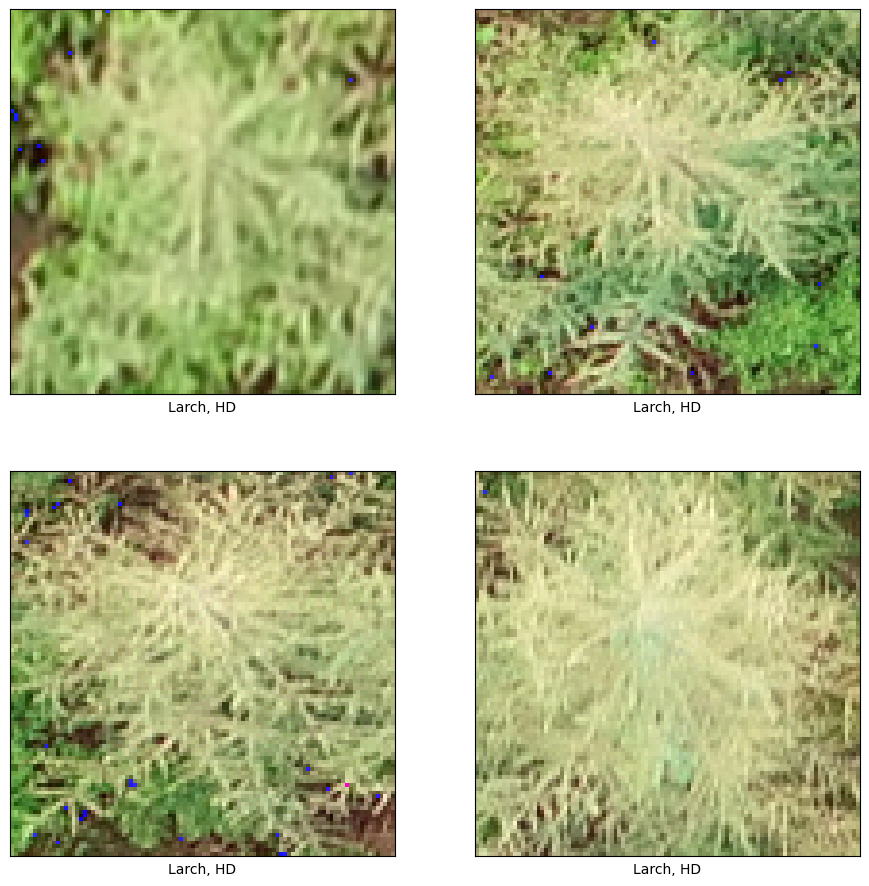

In [380]:
x_train_compressed = test_compression(x_train[:4,:,:,:], 50)
show_images(x_train_compressed[:4], y_train[:4], nb_row = 2)

In [389]:
# flatten array for PCA
x_train_greyscale_flat = x_train_greyscale.reshape(x_train_greyscale.shape[0], img_size[0]**2)
x_test_greyscale_flat = x_test_greyscale.reshape(x_test_greyscale.shape[0], img_size[0]**2)
print(np.shape(x_train_greyscale_flat))
print(np.shape(x_test_greyscale_flat))

#dimension reduction to 2 Principal components
pca = PCA(2)
x_train_pca = pca.fit_transform(x_train_greyscale_flat)
x_test_pca = pca.fit_transform(x_test_greyscale_flat)
print(np.shape(x_train_pca))
print(np.shape(x_test_pca))

(18829, 10000)
(913, 10000)
(18829, 2)
(913, 2)


In [390]:
# split the training dat to training and validation
split_index = int(0.8*x_train_greyscale.shape[0])
x_val_pca = x_train_pca[split_index:]
x_train_pca = x_train_pca[:split_index]
y_val_pca = y_train_damage_ohe[split_index:]
y_train_pca = y_train_damage_ohe[:split_index]

**<span style="font-size:1.7em;">K-Nearest Neighbor Classification:</span>**

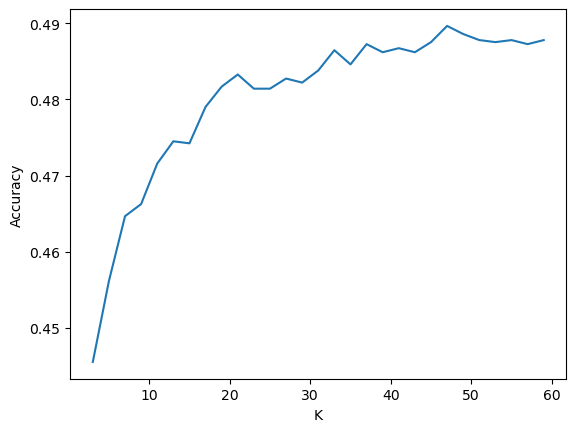

In [401]:
#To implement Nearest Neighbour, we have to use the following input and output parameter
#Input --> x_train_grey, Size: (20522, 2)
#Output(label) --> y_train_damage_ohe, Size: (20522, 4)

acc = {}
for k in range(3, 60, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train_pca)
    y_pred_knn = knn.predict(x_val_pca)
    acc[k] = accuracy_score(y_val_pca, y_pred_knn)
    
# PLotting K v/s accuracy graph
plt.plot(range(3,60,2), acc.values())
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [402]:
# Accuracy doesn't improve after k=40 ==> Optimal K value is 40
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(x_train_pca, y_train_pca)
y_pred_knn = knn.predict(x_test_pca)
print(accuracy_score(y_test_damage_ohe, y_pred_knn))
print(classification_report(y_test_damage_ohe, y_pred_knn))

0.5279299014238773
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       278
           1       0.60      0.91      0.72       455
           2       0.00      0.00      0.00        20
           3       0.76      0.42      0.55       160

   micro avg       0.62      0.53      0.57       913
   macro avg       0.34      0.33      0.32       913
weighted avg       0.43      0.53      0.46       913
 samples avg       0.53      0.53      0.53       913



/Users/mustafaalberri/anaconda3/envs/PAS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mustafaalberri/anaconda3/envs/PAS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


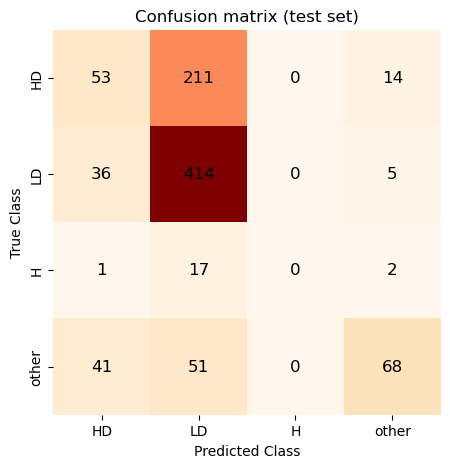

In [409]:
y_pred_knn_classes = np.argmax(y_pred_knn, axis=1)

confusion_knn = confusion_matrix(y_test_damage_classes, y_pred_knn_classes)

plot_confusion(confusion_knn)

**<span style="font-size:1.7em;">SVM Classification:</span>**

In [413]:
# SVM classification:

test_range = 100
ncomponents = 100
var_ratio = []
for num in range(ncomponents):
  pca = PCA(n_components=num)
  pca.fit(x_train_greyscale_flat[:test_range,:])
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

0.9021325614189494


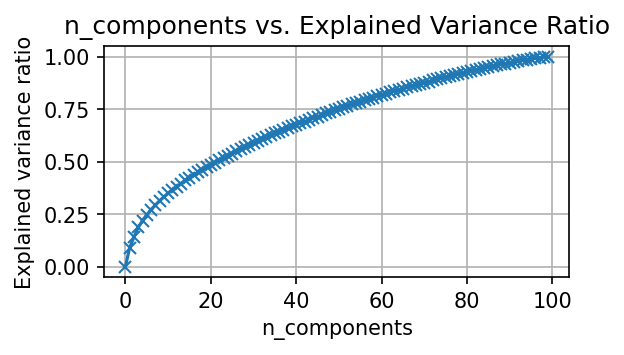

In [415]:
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(np.arange(test_range),var_ratio,marker='x')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
print(var_ratio[75])

In [428]:
# Do compression by choosing 75 principal components

pca = PCA(75)
x_train_pca_75 = pca.fit_transform(x_train_greyscale_flat)
x_test_pca_75 = pca.fit_transform(x_test_greyscale_flat)

y_train_damage_classes = np.argmax(y_train_damage_ohe, axis=1)

print('x_train_pca_75.shape: ', x_train_pca_75.shape)
print('x_test_pca_75.shape: ', x_test_pca_75.shape)

x_train_pca_75.shape:  (18829, 75)
x_test_pca_75.shape:  (913, 75)


In [429]:
# split the training dat to training and validation
split_index = int(0.8*x_train_greyscale.shape[0])
x_val_pca_75 = x_train_pca_75[split_index:]
x_train_pca_75 = x_train_pca_75[:split_index]
y_val_pca_75 = y_train_damage_classes[split_index:]
y_train_pca_75 = y_train_damage_classes[:split_index]

In [430]:
# "train" SVM
svm_model = svm.SVC(decision_function_shape='ovo')
svm_model.fit(x_train_pca_75, y_train_pca_75)

SVC(decision_function_shape='ovo')

In [431]:
#validate SVM
y_pred = svm_model.predict(x_val_pca_75)

correct_pred = 0
false_pred = 0

for prediction, label in zip(y_pred, y_val_pca_75): 
    
    if prediction == label:
        correct_pred += 1

acc = correct_pred/np.shape(y_val_pca_75)[0]
print(acc)

#acc for 'ovo' and 75 PCA: 53.6%
#acc for 'ovr' and 75 PCA: 53.5%
#acc for 'ovr' and 90 PCA: 53.7%
#acc for 'ovo' and 90 PCA: 53,6%
#acc for 'ovo' and 2 PCA : 50,8%

0.5597450876261285


In [433]:
#use svm to predict test values
y_pred_svm = svm_model.predict(x_test_pca_75)

correct_test_pred = 0
false_test_pred = 0

for prediction, label in zip(y_pred_svm, y_test_damage_classes): 
    
    if prediction == label:
        correct_test_pred += 1

acc = correct_test_pred/np.shape(y_test_damage_classes)[0]
print(acc)
# 57%

0.5706462212486308


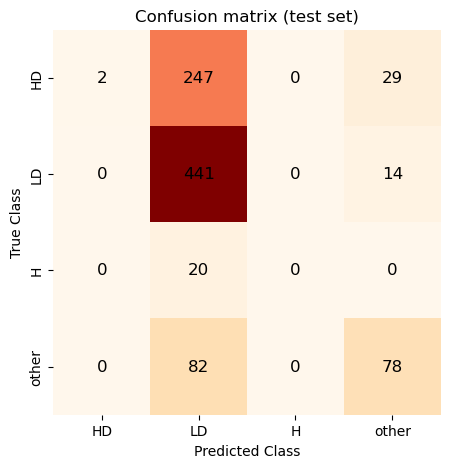

In [435]:
confusion_svm = confusion_matrix(y_test_damage_classes, y_pred_svm)

plot_confusion(confusion_svm)

In [436]:
#"train" SVM, balanced
svm_model_balanced = svm.SVC(decision_function_shape='ovo', class_weight='balanced')
svm_model_balanced.fit(x_train_pca_75, y_train_pca_75)

SVC(class_weight='balanced', decision_function_shape='ovo')

In [438]:
# validate balanced SVM, try different ovo,ovr,...
y_pred_svm_balanced_val = svm_model_balanced.predict(x_val_pca_75)

correct_balanced_pred = 0
false_balanced_pred = 0

for prediction, label in zip(y_pred_svm_balanced_val, y_val_pca_75): 
    
    if prediction == label:
        correct_balanced_pred += 1

acc_balanced = correct_balanced_pred/np.shape(y_val_pca_75)[0]
print(acc_balanced)
#for 75 PCA: 48.3%

0.48274030801911844


In [440]:
#use svm to predict test values
y_pred_svm_balanced = svm_model_balanced.predict(x_test_pca_75)

correct_test_pred = 0
false_test_pred = 0

for prediction, label in zip(y_pred_svm_balanced, y_test_damage_classes): 
    
    if prediction == label:
        correct_test_pred += 1

acc_balanced_test = correct_test_pred/np.shape(y_test_damage_classes)[0]
print(acc_balanced_test)
# 51.37%

0.5136911281489595


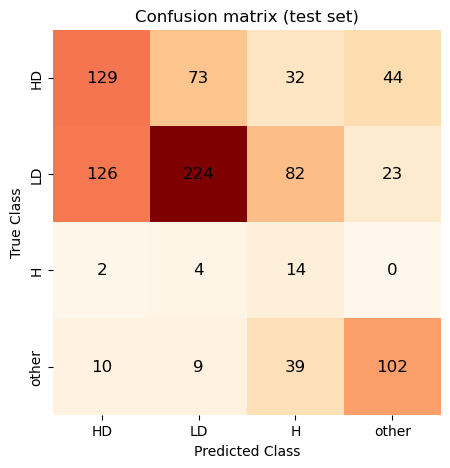

In [441]:
confusion_svm_balanced = confusion_matrix(y_test_damage_classes, y_pred_svm_balanced)

plot_confusion(confusion_svm_balanced)

**<span style="font-size:1.3em;">Weighted Sampling for CNN training:</span>**

In [449]:
weight_for_HD = 1.8
weight_for_LD = 1
weight_for_H = 10 
weight_for_other = 3

# Calculate sample weights
sample_weight = []
for sample in y_train_damage_ohe:
    if np.array_equal(sample,np.array([1,0,0,0])):
        sample_weight.append(weight_for_HD)
    elif np.array_equal(sample,np.array([0,1,0,0])):
        sample_weight.append(weight_for_LD)
    elif np.array_equal(sample,np.array([0,0,1,0])):
        sample_weight.append(weight_for_H)
    elif np.array_equal(sample,np.array([0,0,0,1])):
        sample_weight.append(weight_for_other)
sample_weight = np.transpose(sample_weight)
print(sample_weight)
print(len(sample_weight))
print(len(y_train_damage_ohe))

[1.8 1.8 1.8 ... 3.  3.  3. ]
18829
18829


In [450]:
# Set to True if you want to train the model, else a trained model will be loaded
train_model = False

if train_model:
    # Define a callback such that the model with the best validation accuracy gets saved during training
    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath="./export_models/tree_classifier_{epoch}.keras",
            save_best_only=True,
            monitor="val_accuracy",
            verbose=1,)]
    # Training the model
    history = model.fit(
        x_train,
        y_train_damage_ohe,
        epochs=20,
        batch_size=8,
        validation_split=0.2,
        callbacks=callbacks_list,
        sample_weight=sample_weight)
    # Save model after training
    model.save('./export_models/tree_classifier_trained.keras')
else:
    # Load a trained model
    # model = models.load_model('./export_models/tree_classifier_best.keras')

Epoch 1/20
1881/1883 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7376 - loss: 1.1790

KeyboardInterrupt: 